In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.regularizers import L2

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2, T2V

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
Tamano de la serie temporal 2
shape train/val (17396, 96, 1, 1) (8659, 96, 1, 1) (8587, 96, 1, 1)
(17396, 96, 1, 1)
/home/blasting/TFG_TimeSeries/notebooks/utils.py:133: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/bl

In [3]:
from sklearn.metrics import mean_absolute_error

def evaluate_forecasts(test, forecasts, n_seq):
    errors = list()
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        mse = mean_absolute_error(actual, predicted)
        errors.append(mse)
        print('t+%d MSE: %f' % ((i+1), mse))
    return np.sum(errors)

In [7]:
from skopt.space import Integer, Categorical
from skopt import plots, gp_minimize
from skopt.plots import plot_objective
#from bayes_opt import BayesianOptimization
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram
#import GPy, GPyOpt
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


layer_type = 'DENSE'
forecast_horizon = 6
epochs = 50
batch_size = 256
n_neurons = int(2/3*(X_train.shape[1]*X_train.shape[2]))
n_layers = 2

tf.random.set_seed(42)

def dense_layer_fmethod(inputs, n_neurons):
    return tfk.layers.Dense(n_neurons)(inputs)

def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


def RNN_objective(params, n_layers=2, y_val=y_val, X_val=X_val):
    params = {dim.name: val for dim, val in zip(space, params)}
    print(params)

    inputs = keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    aux_layer = T2V(params['time2vec_dim'])(inputs)
    for key_param, param in params.items():
        if 'regularizer' in key_param:
            params[key_param] = L2(param)

    flatten_outputs = tfk.layers.Flatten()(aux_layer)


    dnn_output = tfk.layers.Dense(n_neurons, activation='relu')(flatten_outputs)

    dnn_output = tfk.layers.Dense(n_neurons,
    activation='relu')(dnn_output)


    outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(dnn_output)

    model = tfk.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
    metrics=[tfk.metrics.MeanAbsoluteError()],
    )


    history = model.fit(X_train, y_train, 
            batch_size=batch_size, 
            epochs=epochs, 
            validation_data=(X_val, y_val),
            #callbacks=[modelckpt_callback],
            verbose=0
    )

    y_hat = model.predict(X_val)
    print("y_hat shape", y_hat.shape)
    print("y_val shape", y_hat.shape)

    loss = history.history['loss']            #entrenamiento
    val_loss = history.history['val_loss']    #validacion

    #Bayes minimiza la funcion
    y_val, y_hat = inverse_transform(y_hat, y_val, scaler)
    sum_errors = evaluate_forecasts(y_val, y_hat, 6)

    return sum_errors

space = [Integer(32, 512, prior='uniform',                       name='time2vec_dim')
        ] 
#1440
#6
#200
result = gp_minimize(RNN_objective,
            space,
            n_calls=20,
            verbose=2)

Iteration No: 1 started. Evaluating function at random point.
{'time2vec_dim': 359}
y_hat shape (8659, 6)
y_val shape (8659, 6)
t+1 MSE: 326.346306
t+2 MSE: 394.721232
t+3 MSE: 429.853362
t+4 MSE: 478.972207
t+5 MSE: 520.985757
t+6 MSE: 543.671653
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 576.7787
Function value obtained: 2694.5505
Current minimum: 2694.5505
Iteration No: 2 started. Evaluating function at random point.
{'time2vec_dim': 137}
y_hat shape (8659, 6)
y_val shape (8659, 6)
t+1 MSE: 270.582590
t+2 MSE: 333.277060
t+3 MSE: 384.199698
t+4 MSE: 399.790885
t+5 MSE: 455.303149
t+6 MSE: 546.596573
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 220.6261
Function value obtained: 2389.7500
Current minimum: 2389.7500
Iteration No: 3 started. Evaluating function at random point.
{'time2vec_dim': 217}
y_hat shape (8659, 6)
y_val shape (8659, 6)
t+1 MSE: 265.001895
t+2 MSE: 339.078157
t+3 MSE: 362.269506
t+4 MSE: 407.326536
t+5 MSE: 428.82597

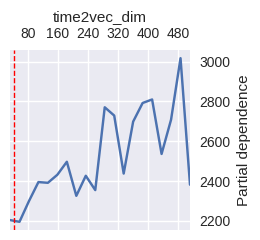

In [17]:
#plt.style.use('science')
plt.style.use('seaborn')

_ = plot_objective(result, n_points=20)

In [28]:
(250.269898 + 282.927276 + 327.633204 + 378.060039 + 423.545160 + 485.892512)/6

358.0546815

In [24]:
_[0]

TypeError: 'AxesSubplot' object is not subscriptable

In [34]:
result.x

[2.332405639894199e-06,
 1.3636176932983914e-05,
 3.225526489539723e-06,
 0.20109655548007943]

In [25]:
result.x

[42]